BASE_DIR = C:\Users\Aishik C\Desktop\neuromorphic\neuromorphic_project\one_node_sim
SNN class loaded from: C:\Users\Aishik C\Desktop\neuromorphic\neuromorphic_project\forest_fire_snn.py
Trained model loaded successfully from: C:\Users\Aishik C\Desktop\neuromorphic\neuromorphic_project\trained_snn_model.pth


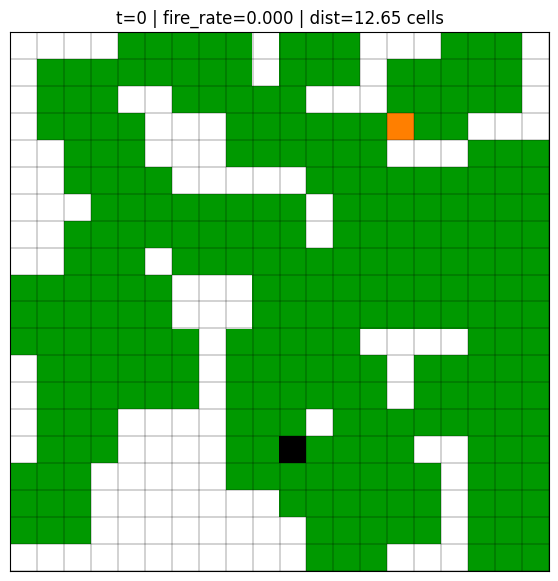

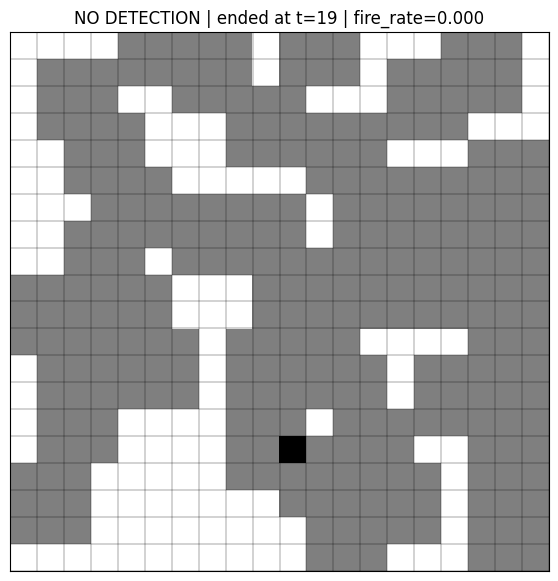

SNN did NOT detect fire within max_steps.
fire_xy: (14, 16) | sensor_xy: (10, 4) | dist=12.65 cells
generate_world(100) done. sensor_xy = (87, 0)


In [ ]:
# world_fire_sim_mcarthur_snn.py  (NOTEBOOK-SAFE VERSION)
# - No __file__ usage (works in Jupyter)
# - Loads trained SNN (4 inputs: Temp, Audio, Humidity, CO2)
# - Generates world with EXACT forest rules
# - (Optional) runs one fire simulation + plots only t=0 and detection (or final)
# - Draws grid lines so every pixel is visible
# - Runs generate_world(100, ...) at the very end (as requested)

from pathlib import Path
import sys
import random
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Base dir + find files
BASE_DIR = Path(r"C:\Users\Aishik C\Desktop\neuromorphic\neuromorphic_project\one_node_sim").resolve()
print("BASE_DIR =", BASE_DIR)

def find_upwards(start_dir: Path, filename: str, max_levels: int = 10):
    """Search for filename in start_dir and its parents; return full path if found."""
    start_dir = start_dir.resolve()
    for i, p in enumerate([start_dir] + list(start_dir.parents)):
        if i > max_levels:
            break
        cand = p / filename
        if cand.exists():
            return cand
    return None

# Locate model + SNN file by searching upward from BASE_DIR
MODEL_PATH = find_upwards(BASE_DIR, "trained_snn_model.pth")
SNN_FILE   = find_upwards(BASE_DIR, "forest_fire_snn.py")

if MODEL_PATH is None:
    raise FileNotFoundError(f"Could not find trained_snn_model.pth searching upward from {BASE_DIR}")
if SNN_FILE is None:
    raise FileNotFoundError(f"Could not find forest_fire_snn.py searching upward from {BASE_DIR}")

PROJECT_ROOT = SNN_FILE.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from forest_fire_snn import SNN  # must NOT auto-train on import

# Load trained model
net = SNN()
ckpt = torch.load(str(MODEL_PATH), map_location="cpu")

# handle raw state_dict OR wrapped checkpoint
if isinstance(ckpt, dict) and any(k in ckpt for k in ("state_dict", "model_state_dict", "net_state_dict")):
    for k in ("state_dict", "model_state_dict", "net_state_dict"):
        if k in ckpt:
            ckpt = ckpt[k]
            break

try:
    net.load_state_dict(ckpt)
except RuntimeError as e:
    # If your checkpoint has extra keys, this avoids crashing and prints the mismatch.
    print("WARNING: load_state_dict strict=True failed. Retrying with strict=False.\n", e)
    net.load_state_dict(ckpt, strict=False)

net.eval()
print("SNN class loaded from:", SNN_FILE)
print("Trained model loaded successfully from:", MODEL_PATH)


# Grid state encoding
EMPTY  = 0   # white
FOREST = 1   # green
BURN   = 2   # orange (burning)
SENSOR = 3   # black
ASH    = 4   # gray (burned out / no fire)


# Neighborhood helper (8-adjacent)
def moore_neighbors(x, y, N):
    """Yield the 8 neighbors that touch (x,y), clipped to grid bounds."""
    for dy in (-1, 0, 1):
        for dx in (-1, 0, 1):
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < N and 0 <= ny < N:
                yield nx, ny


# World generation
def generate_world(N, forest_fraction=0.70, node_x_max=None, node_y_max=None, seed=None):
    """
      1) Pick a random point for the black sensor (SENSOR).
      2) Forest generation:
         - pick a random EMPTY (white) pixel as a forest "center"
         - if that center is already forest, keep picking a new EMPTY one
         - for each of the 8 touching pixels:
             if it's already forest -> skip it
             if it's white (EMPTY) -> turn it into forest
      3) Repeat until forest_fraction of the grid is FOREST.
    """
    rng = random.Random(seed)
    grid = np.full((N, N), EMPTY, dtype=np.uint8)

    if node_x_max is None:
        node_x_max = N - 1
    if node_y_max is None:
        node_y_max = N - 1

    sx = rng.randint(0, min(node_x_max, N - 1))
    sy = rng.randint(0, min(node_y_max, N - 1))
    grid[sy, sx] = SENSOR

    target = int(forest_fraction * (N * N))
    target = min(target, N * N - 1)  # keep at least 1 non-forest cell if possible

    forest_count = 0
    max_attempts = N * N * 50
    attempts = 0

    while forest_count < target and attempts < max_attempts:
        attempts += 1

        cx = rng.randint(0, N - 1)
        cy = rng.randint(0, N - 1)

        # must be EMPTY (white) to start
        if grid[cy, cx] != EMPTY:
            continue

        # set center
        grid[cy, cx] = FOREST
        forest_count += 1
        if forest_count >= target:
            break

        # set neighbors if EMPTY; skip if already forest
        for nx, ny in moore_neighbors(cx, cy, N):
            if grid[ny, nx] == EMPTY:
                grid[ny, nx] = FOREST
                forest_count += 1
                if forest_count >= target:
                    break

    return grid, (sx, sy)

# Choose fire start
def choose_fire_start(grid, sensor_pos=None, min_dist=0, seed=None):
    rng = random.Random(seed)
    forest_cells = np.argwhere(grid == FOREST)
    if forest_cells.size == 0:
        raise ValueError("No FOREST cells available to start a fire.")

    if sensor_pos is None or min_dist <= 0:
        y, x = forest_cells[rng.randrange(len(forest_cells))]
        return (int(x), int(y))

    sx, sy = sensor_pos
    for _ in range(20000):
        y, x = forest_cells[rng.randrange(len(forest_cells))]
        if (x - sx) ** 2 + (y - sy) ** 2 >= min_dist ** 2:
            return (int(x), int(y))

    # fallback
    y, x = forest_cells[rng.randrange(len(forest_cells))]
    return (int(x), int(y))


# McArthur model (as in your screenshot)
def mcarthur_ros_kmh(W, M, V_mpm):
    """
    R = 0.13 * ( 3.35 W e^(-0.0897M + 0.0403V) )                  if M <= 18.8
    R = 0.13 * ( 0.299 W e^(-1.686 + 0.0403V) * (30 - M) )        if 18.8 <= M <= 30
    Units:
      R: km/h
      W: t/hm^2
      M: %
      V: m/min
    """
    M = float(M); W = float(W); V_mpm = float(V_mpm)
    if M <= 18.8:
        return 0.13 * (3.35 * W * np.exp((-0.0897 * M) + (0.0403 * V_mpm)))
    elif M <= 30.0:
        return 0.13 * (0.299 * W * np.exp((-1.686) + (0.0403 * V_mpm)) * (30.0 - M))
    else:
        return 0.0

def ignition_probability_from_ros(R_kmh, dist_m, dt_min, strength=1.0):
    """p = 1 - exp(-strength * (distance_traveled / dist_m))"""
    if dist_m <= 0:
        return 0.0
    R_mpm = (float(R_kmh) * 1000.0) / 60.0
    d = R_mpm * float(dt_min)
    p = 1.0 - np.exp(-float(strength) * (d / float(dist_m)))
    return float(np.clip(p, 0.0, 1.0))

def local_fuel_factor(g, x, y, radius=1):
    """Local fuel availability in [0,1] based on nearby FOREST/BURN."""
    N = g.shape[0]
    y0, y1 = max(0, y - radius), min(N, y + radius + 1)
    x0, x1 = max(0, x - radius), min(N, x + radius + 1)
    patch = g[y0:y1, x0:x1]
    return float(np.mean((patch == FOREST) | (patch == BURN)))


# SNN detection (4 inputs)
def snn_fire_rate(net, sensor_xy, g, patch_R=6, num_steps=25, device="cpu"):
    """
    Builds 4 features: [Temp, Audio, Humidity, CO2] near sensor.
    Outputs class-1 spike rate in [0,1].
    Training normalization:
      Temp/100, Humidity/100, CO2/5000, Audio ~0..1
    """
    sx, sy = sensor_xy
    N = g.shape[0]

    y0, y1 = max(0, sy - patch_R), min(N, sy + patch_R + 1)
    x0, x1 = max(0, sx - patch_R), min(N, sx + patch_R + 1)
    patch = g[y0:y1, x0:x1]

    burning_frac = float(np.mean(patch == BURN))
    ash_frac     = float(np.mean(patch == ASH))

    # map grid signal -> plausible raw sensor units
    temp_nf, audio_nf, humid_nf, co2_nf = 25.0, 0.05, 55.0, 600.0
    temp_f,  audio_f,  humid_f,  co2_f  = 75.0, 0.60, 15.0, 2500.0

    intensity = min(1.0, burning_frac * 4.0 + ash_frac * 1.0)

    temp_raw  = temp_nf  + intensity * (temp_f  - temp_nf)
    audio_raw = audio_nf + intensity * (audio_f - audio_nf)
    humid_raw = humid_nf + intensity * (humid_f - humid_nf)
    co2_raw   = co2_nf   + intensity * (co2_f   - co2_nf)

    # normalize to match training
    temp  = float(np.clip(temp_raw / 100.0, 0.0, 1.0))
    audio = float(np.clip(audio_raw,       0.0, 1.0))
    humid = float(np.clip(humid_raw / 100.0,0.0, 1.0))
    co2   = float(np.clip(co2_raw / 5000.0,0.0, 1.0))

    feats = np.array([temp, audio, humid, co2], dtype=np.float32)

    x = torch.tensor(feats, dtype=torch.float32, device=device).view(1, 1, 4)
    x = x.repeat(num_steps, 1, 1)  # (time, batch, features)

    net = net.to(device)
    net.eval()
    with torch.no_grad():
        spk_rec, _ = net(x)

    return float(spk_rec[:, 0, 1].mean().item())


# Fire spread simulation with McArthur + SNN timing
def simulate_fire_mcarthur_with_snn(
    grid,
    fire_start_xy,
    sensor_xy,
    net,
    fuel_load_W=12.0,
    fuel_moisture_M=12.0,
    wind_speed_mps=3.0,
    dt_min=1.0,
    cell_size_m=30.0,
    strength=1.0,
    patch_R=6,
    num_steps=25,
    fire_rate_threshold=0.20,
    device="cpu",
    max_steps=500,
    seed=None
):
    rng = random.Random(seed)
    N = grid.shape[0]
    x0, y0 = fire_start_xy

    if grid[y0, x0] != FOREST:
        raise ValueError("Fire start must be on a FOREST cell.")

    V_mpm = float(wind_speed_mps) * 60.0  # m/s -> m/min

    g = grid.copy()
    g[y0, x0] = BURN

    for t in range(max_steps + 1):
        fire_rate = snn_fire_rate(net, sensor_xy, g, patch_R=patch_R, num_steps=num_steps, device=device)
        detected = (fire_rate >= fire_rate_threshold)

        burning_cells = np.argwhere(g == BURN)
        if burning_cells.size > 0:
            by, bx = burning_cells[0]
            fuel_factor = local_fuel_factor(g, bx, by, radius=1)
            W_eff = fuel_load_W * fuel_factor
            R_kmh_ex = mcarthur_ros_kmh(W=W_eff, M=fuel_moisture_M, V_mpm=V_mpm)
            p_ignite_ex = ignition_probability_from_ros(R_kmh_ex, dist_m=cell_size_m, dt_min=dt_min, strength=strength)
        else:
            R_kmh_ex = 0.0
            p_ignite_ex = 0.0

        yield t, g.copy(), detected, fire_rate, p_ignite_ex, R_kmh_ex

        if detected:
            break
        if burning_cells.size == 0:
            break  # fire died

        new_g = g.copy()

        for by, bx in burning_cells:
            fuel_factor = local_fuel_factor(g, bx, by, radius=1)
            W_eff = fuel_load_W * fuel_factor
            R_kmh = mcarthur_ros_kmh(W=W_eff, M=fuel_moisture_M, V_mpm=V_mpm)

            for nx, ny in moore_neighbors(bx, by, N):
                if g[ny, nx] != FOREST:
                    continue

                dx = abs(nx - bx)
                dy = abs(ny - by)
                dist_m = cell_size_m * (np.sqrt(2.0) if (dx == 1 and dy == 1) else 1.0)

                p_ignite = ignition_probability_from_ros(
                    R_kmh=R_kmh,
                    dist_m=dist_m,
                    dt_min=dt_min,
                    strength=strength
                )

                if rng.random() < p_ignite:
                    new_g[ny, nx] = BURN

            new_g[by, bx] = ASH

        g = new_g


# Plotting (grid lines ON)
def plot_world(grid, title=None, line_width=0.25, figsize=(7, 7)):
    colors = [
        (1.0, 1.0, 1.0),  # EMPTY
        (0.0, 0.6, 0.0),  # FOREST
        (1.0, 0.5, 0.0),  # BURN
        (0.0, 0.0, 0.0),  # SENSOR
        (0.5, 0.5, 0.5),  # ASH
    ]
    cmap = mcolors.ListedColormap(colors)

    N = grid.shape[0]
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(grid, origin="lower", interpolation="nearest", cmap=cmap, vmin=0, vmax=4)

    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xticks(np.arange(-0.5, N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(which="minor", color="black", linewidth=line_width)
    ax.tick_params(which="minor", bottom=False, left=False)

    if title:
        ax.set_title(title)
    plt.show()

RUN_DEMO = True

if RUN_DEMO:
    # user-tunable params
    N = 20
    forest_fraction = 0.70
    dt_min = 1.0
    cell_size_m = 30.0

    # McArthur environment
    fuel_load_W = 12.0
    fuel_moisture_M = 12.0
    wind_speed_mps = 3.0
    strength = 1.0

    # SNN params
    patch_R = 6
    num_steps = 25
    fire_rate_threshold = 0.20
    device = "cpu"

    # simulation params
    max_steps = 200
    min_dist_from_sensor = patch_R + 2
    line_width = 0.25

    # seeds
    seed_world = 7
    seed_fire = 9
    seed_spread = 3

    world, sensor_xy = generate_world(N, forest_fraction=forest_fraction, seed=seed_world)
    fire_xy = choose_fire_start(world, sensor_pos=sensor_xy, min_dist=min_dist_from_sensor, seed=seed_fire)

    sx, sy = sensor_xy
    fx, fy = fire_xy
    dist = math.sqrt((fx - sx) ** 2 + (fy - sy) ** 2)

    sim_iter = simulate_fire_mcarthur_with_snn(
        grid=world,
        fire_start_xy=fire_xy,
        sensor_xy=sensor_xy,
        net=net,
        fuel_load_W=fuel_load_W,
        fuel_moisture_M=fuel_moisture_M,
        wind_speed_mps=wind_speed_mps,
        dt_min=dt_min,
        cell_size_m=cell_size_m,
        strength=strength,
        patch_R=patch_R,
        num_steps=num_steps,
        fire_rate_threshold=fire_rate_threshold,
        device=device,
        max_steps=max_steps,
        seed=seed_spread
    )

    # plot t=0
    t0, g0, detected0, fire_rate0, p0, R0 = next(sim_iter)
    plot_world(g0, title=f"t=0 | fire_rate={fire_rate0:.3f} | dist={dist:.2f} cells", line_width=line_width)

    t_detect = None
    fire_rate_at_detect = None
    last_t, last_g, last_rate = t0, g0, fire_rate0

    if detected0:
        t_detect = t0
        fire_rate_at_detect = fire_rate0
        plot_world(g0, title=f"DETECTED at t=0 | fire_rate={fire_rate0:.3f}", line_width=line_width)
    else:
        for t, g, detected, fire_rate, p_ex, R_ex in sim_iter:
            last_t, last_g, last_rate = t, g, fire_rate
            if detected:
                t_detect = t
                fire_rate_at_detect = fire_rate
                plot_world(g, title=f"DETECTED at t={t} | fire_rate={fire_rate:.3f}", line_width=line_width)
                break

    if t_detect is None:
        plot_world(last_g, title=f"NO DETECTION | ended at t={last_t} | fire_rate={last_rate:.3f}", line_width=line_width)
        print("SNN did NOT detect fire within max_steps.")
    else:
        print(f"SNN detected fire at timestep t = {t_detect}")
        print(f"Detection time (simulation): {t_detect * dt_min:.2f} minutes")
        print(f"Fire spike-rate at detection: {fire_rate_at_detect:.3f} (threshold={fire_rate_threshold})")

    print(f"fire_xy: {fire_xy} | sensor_xy: {sensor_xy} | dist={dist:.2f} cells")

grid100, sensor100 = generate_world(100, forest_fraction=0.70, seed=None)
print("generate_world(100) done. sensor_xy =", sensor100)


In [ ]:

# Data collection
# VALID = fire reaches a "validity patch"
# SNN reads a smaller patch to avoid dilution
import math
import time
import numpy as np
import pandas as pd
from collections import deque
from pathlib import Path
import matplotlib.pyplot as plt

try:
    from IPython.display import display
except Exception:
    display = print


# Safety check
_required = ["generate_world", "simulate_fire_mcarthur_with_snn", "moore_neighbors",
             "FOREST", "SENSOR", "BURN", "ASH", "net"]
missing = [n for n in _required if n not in globals()]
if missing:
    raise NameError("Missing required definitions from Cell 1: " + ", ".join(missing))


# Settings
N_TRIALS = 50

# World
N = 20
forest_fraction = 0.70

# McArthur / discretization
fuel_load_W = 12.0
fuel_moisture_M = 10.0
wind_speed_mps = 5.0
dt_min = 1.0
cell_size_m = 30.0
strength = 2.5

# Patch radii:
PATCH_R_VALID = 3   # "fire reached the sensor region"
PATCH_R_SNN   = 2   # what the SNN reads (smaller = stronger signal)

num_steps = 25
device = "cpu"

# Simulation
max_steps = 200
PILOT_MAX_STEPS = 80
MAX_SCENARIO_REGEN = 400

# Fire placement constraints
min_dist_from_sensor = max(4, PATCH_R_VALID + 1)
MAX_PATH_LEN = 6
MIN_FOREST_NEIGHBORS = 5

# Adaptive detection (offline)
BASELINE_Q = 0.995
THRESH_MARGIN = 0.004
MIN_THRESHOLD_FLOOR = 0.08  # <- LOWER than before (was 0.12)
PATCH_SIGNAL_EPS = 1e-9

# Reproducibility
MASTER_SEED = 12345
rng = np.random.default_rng(MASTER_SEED)

SHOW_EXAMPLES = 0  # set 1-2 if you want to view a couple trials


# Helpers
def patch_bounds(sensor_xy, R, N):
    sx, sy = sensor_xy
    y0, y1 = max(0, sy - R), min(N, sy + R + 1)
    x0, x1 = max(0, sx - R), min(N, sx + R + 1)
    return x0, x1, y0, y1

def forest_cells_in_patch(grid, sensor_xy, R):
    sx, sy = sensor_xy
    Nloc = grid.shape[0]
    x0, x1, y0, y1 = patch_bounds(sensor_xy, R, Nloc)
    return [(xx, yy) for yy in range(y0, y1) for xx in range(x0, x1) if grid[yy, xx] == FOREST]

def bfs_dist_from_patch(grid, patch_cells):
    Nloc = grid.shape[0]
    dist = -np.ones((Nloc, Nloc), dtype=int)
    q = deque()
    for (x, y) in patch_cells:
        dist[y, x] = 0
        q.append((x, y))
    while q:
        x, y = q.popleft()
        for nx, ny in moore_neighbors(x, y, Nloc):
            if grid[ny, nx] != FOREST:
                continue
            if dist[ny, nx] != -1:
                continue
            dist[ny, nx] = dist[y, x] + 1
            q.append((nx, ny))
    return dist

def count_forest_neighbors(grid, x, y):
    c = 0
    for nx, ny in moore_neighbors(x, y, grid.shape[0]):
        if grid[ny, nx] == FOREST:
            c += 1
    return c

def pick_easy_fire(world, sensor_xy, seed_fire):
    # Build candidates that are connected to the VALID patch and not too far
    patch_cells = forest_cells_in_patch(world, sensor_xy, PATCH_R_VALID)
    if not patch_cells:
        return None, None

    dist_map = bfs_dist_from_patch(world, patch_cells)
    sx, sy = sensor_xy

    candidates = []
    for y in range(N):
        for x in range(N):
            if world[y, x] != FOREST:
                continue
            d = dist_map[y, x]
            if d == -1 or d > MAX_PATH_LEN:
                continue
            if (x - sx) ** 2 + (y - sy) ** 2 < min_dist_from_sensor ** 2:
                continue
            if count_forest_neighbors(world, x, y) < MIN_FOREST_NEIGHBORS:
                continue
            candidates.append((x, y, d))

    if not candidates:
        return None, None

    rr = np.random.default_rng(seed_fire)
    x, y, d = candidates[int(rr.integers(0, len(candidates)))]
    return (int(x), int(y)), int(d)

def mean_std_ci(series):
    s = series.dropna().astype(float)
    n = len(s)
    if n == 0:
        return np.nan, np.nan, 0, np.nan
    mean = float(s.mean())
    std = float(s.std(ddof=1)) if n > 1 else 0.0
    sem = std / math.sqrt(n) if n > 1 else 0.0
    ci95 = 1.96 * sem
    return mean, std, n, ci95

def safe_corr(a, b):
    x = a.astype(float).to_numpy()
    y = b.astype(float).to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]; y = y[mask]
    n = len(x)
    if n < 3 or np.std(x) == 0 or np.std(y) == 0:
        return np.nan, n
    return float(np.corrcoef(x, y)[0, 1]), n


# Run batch (collect N_TRIALS valid)
results = []
regen_failures = 0
wall_start = time.perf_counter()

trial = 0
while trial < N_TRIALS:
    seed_world = int(rng.integers(0, 2**31 - 1))
    seed_fire  = int(rng.integers(0, 2**31 - 1))
    seed_spread= int(rng.integers(0, 2**31 - 1))

    world = sensor_xy = fire_xy = None
    path_len = None
    t_reach_valid = None

    # scenario regen until fire reaches VALID patch
    for regen in range(MAX_SCENARIO_REGEN):
        w, sxy = generate_world(N, forest_fraction=forest_fraction, seed=seed_world + regen)
        fxy, d8 = pick_easy_fire(w, sxy, seed_fire + regen)
        if fxy is None:
            continue

        # Pilot: we only care if fire reaches VALID patch region
        x0v, x1v, y0v, y1v = patch_bounds(sxy, PATCH_R_VALID, N)

        pilot_iter = simulate_fire_mcarthur_with_snn(
            grid=w,
            fire_start_xy=fxy,
            sensor_xy=sxy,
            net=net,
            fuel_load_W=fuel_load_W,
            fuel_moisture_M=fuel_moisture_M,
            wind_speed_mps=wind_speed_mps,
            dt_min=dt_min,
            cell_size_m=cell_size_m,
            strength=strength,
            patch_R=PATCH_R_SNN,            # SNN patch irrelevant for pilot check
            num_steps=num_steps,
            fire_rate_threshold=1.1,        # never stops early
            device=device,
            max_steps=min(max_steps, PILOT_MAX_STEPS),
            seed=seed_spread
        )

        reached = False
        for t, g, det, fr, p_ex, R_ex in pilot_iter:
            if np.any((g[y0v:y1v, x0v:x1v] == BURN) | (g[y0v:y1v, x0v:x1v] == ASH)):
                reached = True
                t_reach_valid = int(t)
                break

        if reached:
            world, sensor_xy, fire_xy, path_len = w, sxy, fxy, d8
            break

    if world is None:
        regen_failures += 1
        continue

    # VALID scenario acquired
    trial += 1

    sx, sy = sensor_xy
    fx, fy = int(fire_xy[0]), int(fire_xy[1])
    dist_cells = float(math.sqrt((fx - sx) ** 2 + (fy - sy) ** 2))

    forest_initial = int(np.sum(world == FOREST))
    sensor_count = int(np.sum(world == SENSOR))
    forest_density = forest_initial / max(1, (N * N - sensor_count))

    # ---- run full sim (never early-break) ----
    wall_t0 = time.perf_counter()
    sim_iter = simulate_fire_mcarthur_with_snn(
        grid=world,
        fire_start_xy=fire_xy,
        sensor_xy=sensor_xy,
        net=net,
        fuel_load_W=fuel_load_W,
        fuel_moisture_M=fuel_moisture_M,
        wind_speed_mps=wind_speed_mps,
        dt_min=dt_min,
        cell_size_m=cell_size_m,
        strength=strength,
        patch_R=PATCH_R_SNN,              # smaller SNN patch
        num_steps=num_steps,
        fire_rate_threshold=1.1,
        device=device,
        max_steps=max_steps,
        seed=seed_spread
    )

    x0s, x1s, y0s, y1s = patch_bounds(sensor_xy, PATCH_R_SNN, N)

    ts = []
    fire_rates = []
    patch_signals = []    # fraction of (BURN or ASH) in SNN patch
    peak_fr = -1.0

    last_t = 0
    last_fr = np.nan
    last_g = world.copy()

    for t, g, det, fr, p_ex, R_ex in sim_iter:
        last_t, last_g, last_fr = int(t), g, float(fr)
        peak_fr = max(peak_fr, float(fr))

        patch = g[y0s:y1s, x0s:x1s]
        sig = float(np.mean((patch == BURN) | (patch == ASH)))

        ts.append(int(t))
        fire_rates.append(float(fr))
        patch_signals.append(sig)

        if SHOW_EXAMPLES and trial <= SHOW_EXAMPLES and t in (0, t_reach_valid):
            plot_world(g, title=f"[Trial {trial}] t={t} | fr={fr:.3f} | sig={sig:.4f}", line_width=0.25)

    wall_dt = time.perf_counter() - wall_t0

    ts = np.array(ts, dtype=int)
    fire_rates = np.array(fire_rates, dtype=float)
    patch_signals = np.array(patch_signals, dtype=float)

    # adaptive threshold from baseline (sig == 0)
    baseline = fire_rates[patch_signals <= PATCH_SIGNAL_EPS]
    if baseline.size >= 5:
        baseline_thr = float(np.quantile(baseline, BASELINE_Q))
    else:
        baseline_thr = float(np.min(fire_rates[:max(1, min(5, len(fire_rates)))]))

    adaptive_threshold = max(MIN_THRESHOLD_FLOOR, baseline_thr + THRESH_MARGIN)

    # gate: require some evidence in patch
    det_mask = (patch_signals > PATCH_SIGNAL_EPS) & (fire_rates >= adaptive_threshold)

    if np.any(det_mask):
        idx = int(np.argmax(det_mask))
        t_detect = int(ts[idx])
        fr_detect = float(fire_rates[idx])
        end_reason = "detected"
    else:
        t_detect = None
        fr_detect = np.nan
        end_reason = "fire_died" if last_t < max_steps else "max_steps"

    # final burn fraction
    final_burning = int(np.sum(last_g == BURN))
    final_ash = int(np.sum(last_g == ASH))
    final_burned = final_burning + final_ash
    final_burned_frac_of_forest = final_burned / max(1, forest_initial)

    results.append({
        "trial": trial,
        "seed_world": seed_world,
        "seed_fire": seed_fire,
        "seed_spread": seed_spread,

        "sensor_x": sx, "sensor_y": sy,
        "fire_x": fx, "fire_y": fy,
        "dist_cells": dist_cells,
        "path_len_8": path_len,
        "t_reach_valid_patch": t_reach_valid,

        "PATCH_R_VALID": PATCH_R_VALID,
        "PATCH_R_SNN": PATCH_R_SNN,

        "detected": (t_detect is not None),
        "t_detect": float(t_detect) if t_detect is not None else np.nan,
        "detect_minutes": (t_detect * dt_min) if t_detect is not None else np.nan,
        "fire_rate_at_detect": fr_detect,
        "peak_fire_rate": peak_fr,

        "adaptive_threshold": adaptive_threshold,
        "baseline_thr_q": baseline_thr,

        "t_end": last_t,
        "fire_rate_end": last_fr,
        "burned_frac_of_forest_end": final_burned_frac_of_forest,

        "end_reason": end_reason,
        "wall_time_s": wall_dt,
    })

df = pd.DataFrame(results)
wall_total = time.perf_counter() - wall_start


# REPORT
total_n = len(df)
det_n = int(df["detected"].sum())
det_rate = det_n / total_n if total_n else 0.0

missed = df[df["detected"] == False]
det_df = df[df["detected"] == True]

print("\n==============================")
print("BATCH RESULTS SUMMARY (VALID=REACH VALID PATCH, SNN READS SMALLER PATCH)")
print("==============================")
print(f"Target valid trials: {N_TRIALS}")
print(f"Valid trials collected: {total_n}")
print(f"World regen failures: {regen_failures}")
print(f"Wall-clock total: {wall_total:.3f} s")
print(f"Detection rate: {det_n}/{total_n} = {det_rate*100:.1f}%")

print("\nFailure breakdown:")
print(missed["end_reason"].value_counts())

mean_t, std_t, n_t, ci_t = mean_std_ci(det_df["t_detect"])
print("\nDetection time (detected trials):")
print(f"t_detect: mean={mean_t:.2f}, std={std_t:.2f}, 95% CI ±{ci_t:.2f}, n={n_t}")

mean_thr, std_thr, n_thr, ci_thr = mean_std_ci(df["adaptive_threshold"])
print("\nAdaptive threshold stats:")
print(f"thr: mean={mean_thr:.3f}, std={std_thr:.3f}, 95% CI ±{ci_thr:.3f}, n={n_thr}")

r1, n1 = safe_corr(det_df["t_detect"], det_df["dist_cells"])
r2, n2 = safe_corr(det_df["t_detect"], det_df["path_len_8"])
print("\nCorrelations (detected only):")
print(f"t_detect vs dist_cells: r={r1:.3f} (n={n1})")
print(f"t_detect vs path_len_8: r={r2:.3f} (n={n2})")

print("\nPeak fire-rate by outcome:")
print(df.groupby("detected")["peak_fire_rate"].describe()[["min","25%","50%","75%","max"]])

# Save CSV
try:
    OUT_DIR = BASE_DIR
except NameError:
    OUT_DIR = Path.cwd()

out_csv = Path(OUT_DIR) / "batch_results_valid_adaptive_PATCHRSPLIT.csv"
df.to_csv(out_csv, index=False)
print(f"\nSaved results CSV: {out_csv}")



BATCH RESULTS SUMMARY (VALID=REACH VALID PATCH, SNN READS SMALLER PATCH)
Target valid trials: 50
Valid trials collected: 50
World regen failures: 0
Wall-clock total: 11.828 s
Detection rate: 43/50 = 86.0%

Failure breakdown:
end_reason
fire_died    7
Name: count, dtype: int64

Detection time (detected trials):
t_detect: mean=7.35, std=3.46, 95% CI ±1.03, n=43

Adaptive threshold stats:
thr: mean=0.080, std=0.000, 95% CI ±0.000, n=50

Correlations (detected only):
t_detect vs dist_cells: r=0.396 (n=43)
t_detect vs path_len_8: r=0.449 (n=43)

Peak fire-rate by outcome:
           min   25%   50%   75%   max
detected                              
False     0.00  0.00  0.00  0.00  0.00
True      0.12  0.24  0.24  0.24  0.24

Saved results CSV: C:\Users\Aishik C\Desktop\neuromorphic\neuromorphic_project\one_node_sim\batch_results_valid_adaptive_PATCHRSPLIT.csv


In [17]:
import numpy as np
import math
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# Parameters
N = 20
forest_fraction = 0.70

# McArthur / discretization
fuel_load_W = 12.0
fuel_moisture_M = 10.0
wind_speed_mps = 5.0
dt_min = 1.0
cell_size_m = 30.0
strength = 2.5

# SNN + detection logic
PATCH_R_SNN = 2
num_steps = 25
device = "cpu"

# Adaptive threshold logic
BASELINE_Q = 0.995
THRESH_MARGIN = 0.004
MIN_THRESHOLD_FLOOR = 0.08
PATCH_SIGNAL_EPS = 1e-9

max_steps = 200

# Save options
SAVE_MP4 = False   # True -> tries mp4 (needs ffmpeg)
SAVE_GIF = True    # True -> saves gif (usually works everywhere)
FPS = 6            # frames per second in the exported file
OUT_DIR = Path.cwd()  # or BASE_DIR

# Helpers
def patch_bounds(sensor_xy, R, N):
    sx, sy = sensor_xy
    y0, y1 = max(0, sy - R), min(N, sy + R + 1)
    x0, x1 = max(0, sx - R), min(N, sx + R + 1)
    return x0, x1, y0, y1

def compute_patch_signal(g, sensor_xy, R):
    x0, x1, y0, y1 = patch_bounds(sensor_xy, R, g.shape[0])
    patch = g[y0:y1, x0:x1]
    return float(np.mean((patch == BURN) | (patch == ASH)))

# Make one scenario
world, sensor_xy = generate_world(N, forest_fraction=forest_fraction, seed=None)
fire_xy = choose_fire_start(world, sensor_pos=sensor_xy, min_dist=PATCH_R_SNN + 2, seed=None)

sx, sy = sensor_xy
fx, fy = fire_xy
dist_cells = math.sqrt((fx - sx)**2 + (fy - sy)**2)


# Run sim & collect frames until DETECT
# We set fire_rate_threshold high so the generator doesn't stop early
sim_iter = simulate_fire_mcarthur_with_snn(
    grid=world,
    fire_start_xy=fire_xy,
    sensor_xy=sensor_xy,
    net=net,
    fuel_load_W=fuel_load_W,
    fuel_moisture_M=fuel_moisture_M,
    wind_speed_mps=wind_speed_mps,
    dt_min=dt_min,
    cell_size_m=cell_size_m,
    strength=strength,
    patch_R=PATCH_R_SNN,
    num_steps=num_steps,
    fire_rate_threshold=1.1,  # never early-stop inside generator
    device=device,
    max_steps=max_steps,
    seed=None
)

frames = []
meta = []  # (t, fire_rate, patch_sig, thr, detected)

baseline_rates = []

t_detect = None

for t, g, detected_unused, fire_rate, p_ex, R_ex in sim_iter:
    t = int(t)
    fr = float(fire_rate)
    sig = compute_patch_signal(g, sensor_xy, PATCH_R_SNN)

    # baseline rates: only when patch shows "no evidence"
    if sig <= PATCH_SIGNAL_EPS:
        baseline_rates.append(fr)

    # adaptive threshold
    if len(baseline_rates) >= 5:
        baseline_thr = float(np.quantile(np.array(baseline_rates), BASELINE_Q))
    elif len(baseline_rates) >= 1:
        baseline_thr = float(min(baseline_rates))
    else:
        baseline_thr = 0.0

    thr = max(MIN_THRESHOLD_FLOOR, baseline_thr + THRESH_MARGIN)

    # detection rule (require patch evidence to avoid t=0 false detects)
    detected = (sig > PATCH_SIGNAL_EPS) and (fr >= thr)

    frames.append(g.copy())
    meta.append((t, fr, sig, thr, detected))

    if detected:
        t_detect = t
        break

# If never detected, still animate full run
if t_detect is None:
    t_detect = meta[-1][0]

print(f"sensor_xy={sensor_xy} fire_xy={fire_xy} dist={dist_cells:.2f} cells")
print(f"Frames collected: {len(frames)}  |  Detect timestep: {t_detect}  |  Sim minutes: {t_detect*dt_min:.2f}")


# Build animation
colors = [
    (1.0, 1.0, 1.0),  # EMPTY
    (0.0, 0.6, 0.0),  # FOREST
    (1.0, 0.5, 0.0),  # BURN
    (0.0, 0.0, 0.0),  # SENSOR
    (0.5, 0.5, 0.5),  # ASH
]
cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(frames[0], origin="lower", interpolation="nearest", cmap=cmap, vmin=0, vmax=4)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])

# gridlines
ax.set_xticks(np.arange(-0.5, N, 1), minor=True)
ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
ax.grid(which="minor", color="black", linewidth=0.25)
ax.tick_params(which="minor", bottom=False, left=False)

title = ax.set_title("")

def update(i):
    im.set_data(frames[i])
    t, fr, sig, thr, det = meta[i]
    title.set_text(
        f"t={t} | minutes={t*dt_min:.1f} | fire_rate={fr:.3f} | sig={sig:.3f} | thr={thr:.3f} | DET={det}"
    )
    return (im, title)

anim = FuncAnimation(fig, update, frames=len(frames), interval=1000/FPS, blit=False)

plt.close(fig)  # prevents duplicate static plot in notebook
display(HTML(anim.to_jshtml()))


# Save to file
OUT_DIR.mkdir(parents=True, exist_ok=True)
stem = f"sim_N{N}_frames{len(frames)}_tDetect{t_detect}"

if SAVE_MP4:
    mp4_path = OUT_DIR / f"{stem}.mp4"
    try:
        anim.save(mp4_path, fps=FPS, dpi=150)
        print("Saved MP4:", mp4_path)
    except Exception as e:
        print("MP4 save failed (likely missing ffmpeg). Error:\n", e)

if SAVE_GIF:
    gif_path = OUT_DIR / f"{stem}.gif"
    try:
        anim.save(gif_path, writer="pillow", fps=FPS)
        print("Saved GIF:", gif_path)
    except Exception as e:
        print("GIF save failed. Error:\n", e)


sensor_xy=(10, 2) fire_xy=(12, 6) dist=4.47 cells
Frames collected: 8  |  Detect timestep: 7  |  Sim minutes: 7.00


Saved GIF: c:\Users\Aishik C\Desktop\neuromorphic\neuromorphic_project\one_node_sim\sim_N20_frames8_tDetect7.gif
